In [115]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
import re
import gc
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

In [116]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fullmodel = T5ForConditionalGeneration.from_pretrained("../datasets/prot_embedding_weights/prottrans_t5_xl_u50/").to(device)

#fullmodel.full() if str(device)=='cpu' else fullmodel.half()

# Load the tokenizer
tokenizer = T5Tokenizer.from_pretrained('../datasets/prot_embedding_weights//prottrans_t5_xl_u50', do_lower_case=False)


In [117]:
def sequence_masker(seq, i, j, same_extra_token=False):
    masked_sequence_list = seq.split()
    token_num = 0
    if j<=i:
        print(f"index j={j} must be greater than i={i}")
        raise
    for x in range(i, j):
        masked_sequence_list[x] = f"<extra_id_{token_num}>"
        if not same_extra_token:
            token_num += 1
    return " ".join(masked_sequence_list)

test = "P R O T E I N A"


In [150]:
import random

testsequence = "PROTEINA"
testsequence = "CQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEED"
input_test = [" ".join(list(re.sub(r"[UZOB]", "X", testsequence)))]
print(input_test)

masked_test = [sequence_masker(input_test[0], 50, 51)]
print(masked_test)

ids1 = tokenizer.batch_encode_plus(input_test, add_special_tokens=True, padding="longest")
# print(ids1)
ids2 = tokenizer.batch_encode_plus(masked_test, add_special_tokens=True, padding="longest")
# print(ids2)

print(tokenizer(input_test[0]))
print(tokenizer(masked_test[0]))

['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C <extra_id_0> A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
{'input_ids': [22, 16, 14, 22, 10, 13, 7, 22, 13, 17, 5, 7, 22, 21, 5, 3, 5, 9, 9, 17, 22, 16, 14, 4, 11, 14, 12, 12, 22, 3, 16, 16, 22, 7, 5, 8, 22, 8, 5, 14, 7, 13, 7, 10, 22, 22, 20, 17, 16, 22, 3, 3, 5, 22, 11, 5, 13, 8, 9, 7, 10, 22, 4, 6, 22, 8, 14, 15, 8, 10, 9, 3, 11, 22, 14, 10, 11, 22, 13, 13, 4, 19, 4, 18, 17, 13, 11, 11, 18, 16, 19, 10, 6, 17, 13, 9, 5, 14, 18, 7, 15, 5, 3, 11, 22, 6, 14, 14, 22, 13, 8, 17, 18, 6, 6, 11, 10, 

In [151]:
input_ids = torch.tensor(ids2['input_ids']).to(device)
attention_mask = torch.tensor(ids2['attention_mask']).to(device)

#embfull = fullmodel(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=input_ids)

In [152]:
with torch.no_grad():
    loss = fullmodel(input_ids=input_ids, labels=input_ids).loss
    print(loss.item())

0.12490568310022354


In [153]:
with torch.no_grad():
    emb = fullmodel(input_ids=input_ids, labels=input_ids)
    loss  = emb.loss.cpu()

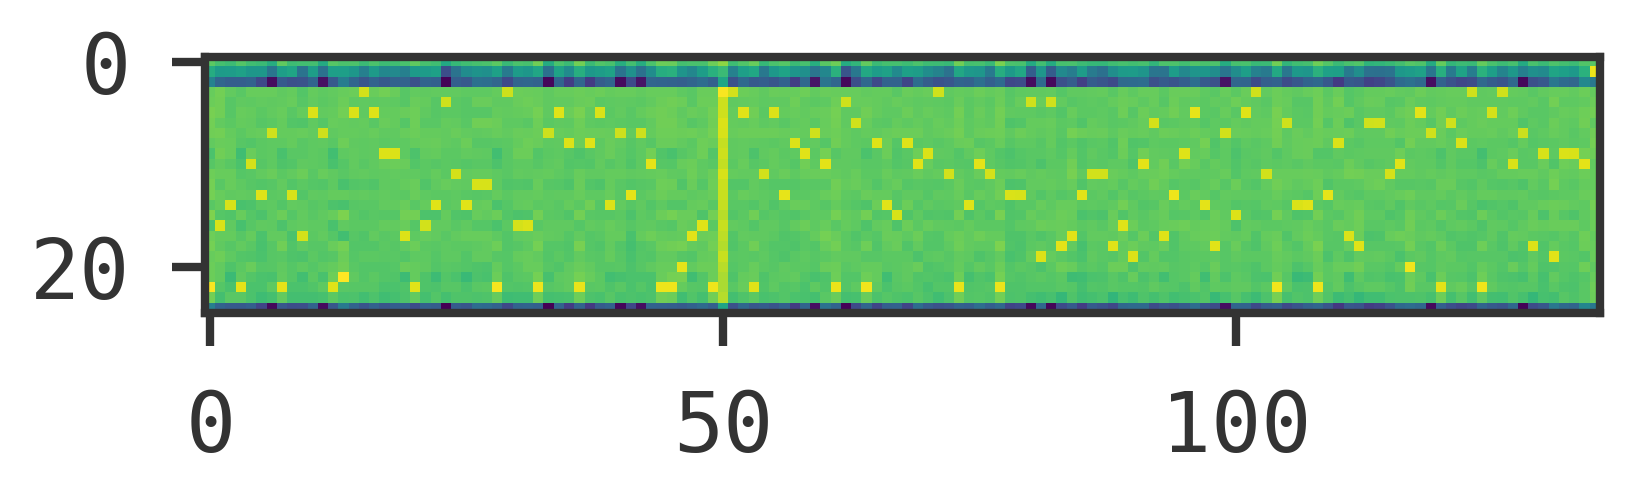

In [156]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# move tensor to cpu
logits_cpu = emb.logits[0,:,0:25].T.cpu()
ax.imshow(np.array(logits_cpu))
#ax.imshow(np.array(emb.logits[0,:,0:25].T))
plt.show()

In [155]:
print(masked_test)
print(input_ids)
with torch.no_grad():
    outputs = fullmodel.generate(input_ids=input_ids, max_length=200)
tokenizer.decode(outputs[0])
# tokenizer.get_vocab()

['C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C <extra_id_0> A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D']
tensor([[ 22,  16,  14,  22,  10,  13,   7,  22,  13,  17,   5,   7,  22,  21,
           5,   3,   5,   9,   9,  17,  22,  16,  14,   4,  11,  14,  12,  12,
          22,   3,  16,  16,  22,   7,   5,   8,  22,   8,   5,  14,   7,  13,
           7,  10,  22,  22,  20,  17,  16,  22, 127,   3,   5,  22,  11,   5,
          13,   8,   9,   7,  10,  22,   4,   6,  22,   8,  14,  15,   8,  10,
           9,   3,  11,  22,  14,  10,  11,  22,  13,  13,   4,  19,   4,  18,
          17,  13,  11,  11,  18,  16,  19,  10,   6,  17,  13,   9,   5,  14,
          18,   7,  15,   5,   3,  11,  22,   6,  14,  14,  22,  13,   8,  17,
          18,   6,   6,  11,  10,  20,   5,   7,  22,   6,   8,   3,  22,   5,
    

'<pad> C Q K C D P S C P N G S C W G A G E E N C Q K L T K I I C A Q Q C S G R C R G K S P S D C C H N Q C A A G C T G P R E S D C L V C R K F R D E A T C K D T C P P L M L Y N P T T Y Q M D V N P E G K Y S F G A T C V K K C P R N Y V V T D H G S C V R A C G A D S Y E M E E D</s>'

In [149]:
testsequence

'CQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGCTGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYVVTDHGSCVRACGADSYEMEED'

In [10]:
# Load one dataset

import json

disprot_file = "AF2_testset.json"
with open(disprot_file) as infmt:
    disprot_dict = json.load(infmt)

In [12]:
from tqdm import tqdm

#torch.backends.cuda.enable_flash_sdp(True)

protids = list(disprot_dict.keys())
loss_dict = dict()
for test_prot in protids:
    #test_prot = protids[3]
    print(test_prot)
    
    target_seq = disprot_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

    loss_sequence = list()
    for i in tqdm(range(len(target_seq))):
        masked_seq = [sequence_masker(input_seq[0], i, i+1)]

        tmp = tokenizer(masked_seq)
        input_ids = torch.tensor(tmp['input_ids']).to(device)
        attention_mask = torch.tensor(tmp['attention_mask']).to(device)
        with torch.no_grad():
            emb  = fullmodel(input_ids=input_ids, labels=input_ids)
            loss = emb.loss.cpu()
            loss_sequence.append(loss.item())
    loss_dict[test_prot] = dict()
    loss_dict[test_prot]["singleaa_loss"] = loss_sequence
    torch.cuda.empty_cache()

P37840


100%|███████████████████████████████████████████████████████████████████████| 140/140 [00:08<00:00, 16.08it/s]


P04637


100%|███████████████████████████████████████████████████████████████████████| 393/393 [00:30<00:00, 12.74it/s]


P02686


100%|███████████████████████████████████████████████████████████████████████| 304/304 [00:19<00:00, 15.87it/s]


P07305


100%|███████████████████████████████████████████████████████████████████████| 194/194 [00:11<00:00, 16.20it/s]


O00488


100%|███████████████████████████████████████████████████████████████████████| 134/134 [00:08<00:00, 16.01it/s]


Q9NYB9


100%|███████████████████████████████████████████████████████████████████████| 513/513 [01:03<00:00,  8.03it/s]


P06401


100%|███████████████████████████████████████████████████████████████████████| 933/933 [05:33<00:00,  2.80it/s]


Q16186


100%|███████████████████████████████████████████████████████████████████████| 407/407 [00:32<00:00, 12.51it/s]


S6B291


100%|███████████████████████████████████████████████████████████████████████| 466/466 [00:47<00:00,  9.91it/s]


P23441


100%|███████████████████████████████████████████████████████████████████████| 372/372 [00:26<00:00, 14.03it/s]


In [13]:
with open("disprot_singleaa_loss.json", 'w') as outfmt:
    json.dump(loss_dict, outfmt)

In [ ]:

# fig = plt.figure(figsize=(6,6), dpi=100)
# ax = fig.add_subplot(111)
# ax.scatter(np.arange(len(target_seq)), loss_sequence)
# plt.show()

In [16]:

protids = list(disprot_dict.keys())
loss5_dict = dict()
for test_prot in protids:
    #test_prot = protids[3]
    print(test_prot)
    
    target_seq = disprot_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

    loss_sequence = list()
    for i in tqdm(range(len(target_seq)-5)):
        masked_seq = [sequence_masker(input_seq[0], i, i+5)]

        tmp = tokenizer(masked_seq)
        input_ids = torch.tensor(tmp['input_ids']).to(device)
        attention_mask = torch.tensor(tmp['attention_mask']).to(device)
        with torch.no_grad():
            emb  = fullmodel(input_ids=input_ids, labels=input_ids)
            loss = emb.loss.cpu()
            loss_sequence.append(loss.item())
    loss5_dict[test_prot] = dict()
    loss5_dict[test_prot]["5aa_loss"] = loss_sequence
    torch.cuda.empty_cache()
    
with open("disprot_5aa_loss.json", 'w') as outfmt:
    json.dump(loss5_dict, outfmt)

P37840


100%|███████████████████████████████████████████████████████████████████████| 135/135 [00:08<00:00, 16.08it/s]


P04637


100%|███████████████████████████████████████████████████████████████████████| 388/388 [00:30<00:00, 12.58it/s]


P02686


100%|███████████████████████████████████████████████████████████████████████| 299/299 [00:19<00:00, 15.67it/s]


P07305


100%|███████████████████████████████████████████████████████████████████████| 189/189 [00:11<00:00, 15.78it/s]


O00488


100%|███████████████████████████████████████████████████████████████████████| 129/129 [00:07<00:00, 16.16it/s]


Q9NYB9


100%|███████████████████████████████████████████████████████████████████████| 508/508 [01:04<00:00,  7.94it/s]


P06401


100%|███████████████████████████████████████████████████████████████████████| 928/928 [05:29<00:00,  2.82it/s]


Q16186


100%|███████████████████████████████████████████████████████████████████████| 402/402 [00:31<00:00, 12.68it/s]


S6B291


100%|███████████████████████████████████████████████████████████████████████| 461/461 [00:45<00:00, 10.07it/s]


P23441


100%|███████████████████████████████████████████████████████████████████████| 367/367 [00:25<00:00, 14.13it/s]


In [17]:
monomer_file = "monomer_datadict.json"
with open(monomer_file) as infmt:
    monomer_dict = json.load(infmt)

In [18]:
protids = list(monomer_dict.keys())
loss_dict = dict()
for test_prot in protids:
    #test_prot = protids[3]
    print(test_prot)
    
    target_seq = monomer_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

    loss_sequence = list()
    for i in tqdm(range(len(target_seq))):
        masked_seq = [sequence_masker(input_seq[0], i, i+1)]

        tmp = tokenizer(masked_seq)
        input_ids = torch.tensor(tmp['input_ids']).to(device)
        attention_mask = torch.tensor(tmp['attention_mask']).to(device)
        with torch.no_grad():
            emb  = fullmodel(input_ids=input_ids, labels=input_ids)
            loss = emb.loss.cpu()
            loss_sequence.append(loss.item())
    loss_dict[test_prot] = dict()
    loss_dict[test_prot]["singleaa_loss"] = loss_sequence
    torch.cuda.empty_cache()
    
with open("monomer_singleaa_loss.json", 'w') as outfmt:
    json.dump(loss_dict, outfmt)

1AE9A


100%|███████████████████████████████████████████████████████████████████████| 179/179 [00:11<00:00, 15.86it/s]


1AH7A


100%|███████████████████████████████████████████████████████████████████████| 245/245 [00:15<00:00, 16.01it/s]


1AHOA


100%|█████████████████████████████████████████████████████████████████████████| 64/64 [00:03<00:00, 16.87it/s]


1AOCA


100%|███████████████████████████████████████████████████████████████████████| 175/175 [00:10<00:00, 16.84it/s]


1AOLA


100%|███████████████████████████████████████████████████████████████████████| 228/228 [00:13<00:00, 16.49it/s]


1AQZA


100%|███████████████████████████████████████████████████████████████████████| 149/149 [00:09<00:00, 15.64it/s]


1ATGA


100%|███████████████████████████████████████████████████████████████████████| 231/231 [00:14<00:00, 16.16it/s]


1ATZA


100%|███████████████████████████████████████████████████████████████████████| 189/189 [00:11<00:00, 16.14it/s]


1AYOB


100%|███████████████████████████████████████████████████████████████████████| 130/130 [00:07<00:00, 16.79it/s]


1AZOA


100%|███████████████████████████████████████████████████████████████████████| 232/232 [00:14<00:00, 15.78it/s]


1B9WA


100%|█████████████████████████████████████████████████████████████████████████| 95/95 [00:06<00:00, 15.72it/s]


In [19]:

protids = list(monomer_dict.keys())
loss5_dict = dict()
for test_prot in protids:
    #test_prot = protids[3]
    print(test_prot)
    
    target_seq = monomer_dict[test_prot]['seq']
    input_seq = [" ".join(list(re.sub(r"[UZOB]", "X", target_seq)))]

    loss_sequence = list()
    for i in tqdm(range(len(target_seq)-5)):
        masked_seq = [sequence_masker(input_seq[0], i, i+5)]

        tmp = tokenizer(masked_seq)
        input_ids = torch.tensor(tmp['input_ids']).to(device)
        attention_mask = torch.tensor(tmp['attention_mask']).to(device)
        with torch.no_grad():
            emb  = fullmodel(input_ids=input_ids, labels=input_ids)
            loss = emb.loss.cpu()
            loss_sequence.append(loss.item())
    loss5_dict[test_prot] = dict()
    loss5_dict[test_prot]["5aa_loss"] = loss_sequence
    torch.cuda.empty_cache()
    
with open("monomer_5aa_loss.json", 'w') as outfmt:
    json.dump(loss5_dict, outfmt)

1AE9A


100%|███████████████████████████████████████████████████████████████████████| 174/174 [00:10<00:00, 15.89it/s]


1AH7A


100%|███████████████████████████████████████████████████████████████████████| 240/240 [00:15<00:00, 15.87it/s]


1AHOA


100%|█████████████████████████████████████████████████████████████████████████| 59/59 [00:03<00:00, 15.99it/s]


1AOCA


100%|███████████████████████████████████████████████████████████████████████| 170/170 [00:10<00:00, 15.94it/s]


1AOLA


100%|███████████████████████████████████████████████████████████████████████| 223/223 [00:13<00:00, 16.48it/s]


1AQZA


100%|███████████████████████████████████████████████████████████████████████| 144/144 [00:08<00:00, 16.42it/s]


1ATGA


100%|███████████████████████████████████████████████████████████████████████| 226/226 [00:14<00:00, 16.07it/s]


1ATZA


100%|███████████████████████████████████████████████████████████████████████| 184/184 [00:11<00:00, 16.01it/s]


1AYOB


100%|███████████████████████████████████████████████████████████████████████| 125/125 [00:07<00:00, 16.31it/s]


1AZOA


100%|███████████████████████████████████████████████████████████████████████| 227/227 [00:13<00:00, 16.78it/s]


1B9WA


100%|█████████████████████████████████████████████████████████████████████████| 90/90 [00:05<00:00, 16.69it/s]
